In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import datetime
import json
import os
from joblib import Parallel, delayed
from time import sleep, time
import logging


import itertools
import holidays
import keras
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import requests
import seaborn as sns
import statsmodels
import statsmodels.tsa.api as sm
import tensorflow as tf
import xgboost as xgb
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout

from matplotlib import rcParams  # Used to set default paremeters

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import month_plot, plot_acf, plot_pacf, quarter_plot


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data/Long_Data.csv', index_col=0)

# Change column names to lower case and drop id (row number)
df.columns = df.columns.str.lower()

In [ ]:
df.sample(n=7)

,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,...,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,scottish_transfer,viking_flow,is_holiday
150675,2017-08-06,6,18597,19694,16689,559,5305,0,12372,0,...,0,693,248,504,0,NaN,NaN,NaN,NaN,0
87901,2014-01-06,14,34024,34643,31127,1472,2434,0,3366,0,...,0,102,81,127,0,NaN,NaN,NaN,NaN,0
3462,2009-03-14,7,28741,31221,25850,998,1419,0,0,0,...,0,0,61,0,0,NaN,NaN,NaN,NaN,0
234873,2022-05-26,12,19211,23435,17786,2017,6545,227,13852,0,...,-1028,-855,247,504,642,693.0,-804.0,NaN,NaN,0
36032,2011-01-21,33,49644,50706,44945,331,1730,2,88,0,...,0,0,-451,0,0,NaN,NaN,NaN,NaN,0
196881,2020-03-25,34,30546,31946,27478,718,6559,2470,13080,0,...,0,999,-253,-536,1020,0.0,0.0,NaN,NaN,0
40302,2011-04-20,32,38925,39853,35244,66,1761,56,146,0,...,0,0,-412,0,0,NaN,NaN,NaN,NaN,0


In [ ]:
df.describe()

,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,...,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,scottish_transfer,viking_flow,is_holiday
count,267168.000000,267168.000000,267168.000000,267168.000000,267168.000000,267168.000000,267168.000000,267168.000000,267168.000000,267168.000000,...,267168.000000,267168.000000,267168.000000,267168.000000,267168.000000,91872.000000,91872.000000,21744.000000,21744.000000,267168.000000
mean,24.500225,31481.343331,32900.548730,28649.181062,1250.682492,4350.736885,831.076697,8287.481124,6.955489,311.277634,...,31.838963,521.535371,-117.552278,-38.061411,161.687470,319.934169,46.640184,1822.392292,109.798657,0.022637
std,13.853814,7798.869984,7700.569786,7066.753739,954.066159,1946.033161,1638.355773,5696.942896,40.001060,535.968754,...,331.032165,527.025721,228.075302,256.576114,406.115387,601.562333,452.463354,1923.805410,361.980818,0.148745
min,1.000000,13367.000000,0.000000,0.000000,0.000000,1403.000000,0.000000,0.000000,-24.000000,0.000000,...,-1030.000000,-1215.000000,-505.000000,-585.000000,-1022.000000,-1455.000000,-1028.000000,-2851.000000,-1465.000000,0.000000
25%,12.750000,25236.000000,26885.000000,22968.000000,540.000000,2092.000000,0.000000,1957.000000,0.000000,8.000000,...,0.000000,0.000000,-279.000000,-170.000000,0.000000,0.000000,0.000000,291.000000,0.000000,0.000000
50%,24.500000,30868.000000,32108.000000,28088.000000,1000.000000,4276.000000,0.000000,11100.000000,0.000000,11.000000,...,0.000000,747.000000,-135.000000,0.000000,0.000000,0.000000,0.000000,1649.000000,0.000000,0.000000
75%,36.250000,37202.000000,38369.000000,33873.000000,1700.000000,6488.000000,799.000000,13080.000000,0.000000,397.000000,...,0.000000,994.000000,36.000000,0.000000,117.000000,693.000000,0.000000,3241.000000,0.000000,0.000000
max,50.000000,59095.000000,60147.000000,53325.000000,5587.000000,6574.000000,9830.000000,15954.000000,893.000000,2019.000000,...,1016.000000,1143.000000,499.000000,504.000000,1033.000000,1401.000000,1002.000000,6585.000000,1420.000000,1.000000


In [ ]:
df.shape

(267168, 22)

In [ ]:
# Sort values by date
df.sort_values(
    by=["settlement_date", "settlement_period"], inplace=True, ignore_index=True
)

In [ ]:
df.isna().any()

settlement_date              False
settlement_period            False
nd                           False
tsd                          False
england_wales_demand         False
embedded_wind_generation     False
embedded_wind_capacity       False
embedded_solar_generation    False
embedded_solar_capacity      False
non_bm_stor                  False
pump_storage_pumping         False
ifa_flow                     False
ifa2_flow                    False
britned_flow                 False
moyle_flow                   False
east_west_flow               False
nemo_flow                    False
nsl_flow                      True
eleclink_flow                 True
scottish_transfer             True
viking_flow                   True
is_holiday                   False
dtype: bool

As can be seen, only two columns include `nan` values. Let's check how many `nan` values there are in each column:

In [ ]:
pd.concat(
    [
        df["nsl_flow"].isna().value_counts().to_frame(),
        df["eleclink_flow"].isna().value_counts().to_frame(),
    ],
    axis=1,
    ignore_index=True,
).rename(columns={0: "nsl_flow", 1: "eleclink_flow"})

,nsl_flow,eleclink_flow
True,175296,175296
False,91872,91872


It seems that both features have the same number of `nan` values. Let's have a look at that the dataframe containing the `nan` value:

In [ ]:
df.loc[(df["eleclink_flow"].isna()) | (df["nsl_flow"].isna()), :]

,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,...,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,scottish_transfer,viking_flow,is_holiday
0,2009-01-01,1,37910,38704,33939,54,1403,0,0,0,...,0,0,-161,0,0,NaN,NaN,NaN,NaN,1
1,2009-01-01,2,38047,38964,34072,53,1403,0,0,0,...,0,0,-160,0,0,NaN,NaN,NaN,NaN,1
2,2009-01-01,3,37380,38651,33615,53,1403,0,0,0,...,0,0,-160,0,0,NaN,NaN,NaN,NaN,1
3,2009-01-01,4,36426,37775,32526,50,1403,0,0,0,...,0,0,-160,0,0,NaN,NaN,NaN,NaN,1
4,2009-01-01,5,35687,37298,31877,50,1403,0,0,0,...,0,0,-160,0,0,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175291,2018-12-31,44,26826,28428,25195,2734,5918,0,13052,0,...,0,777,-454,-535,0,NaN,NaN,NaN,NaN,0
175292,2018-12-31,45,25660,27542,24145,2730,5918,0,13052,0,...,0,-268,-455,-536,0,NaN,NaN,NaN,NaN,0
175293,2018-12-31,46,25047,26971,23496,2726,5918,0,13052,0,...,0,-297,-455,-536,0,NaN,NaN,NaN,NaN,0
175294,2018-12-31,47,24188,26224,22683,2673,5918,0,13052,0,...,0,-467,-454,-466,0,NaN,NaN,NaN,NaN,0


In [ ]:
df.drop(columns=["nsl_flow", "eleclink_flow","viking_flow","scottish_transfer"], axis=1, inplace=True)

# Drop rows where settlement_period value is greater than 48
df.drop(index=df[df["settlement_period"] > 48].index, inplace=True)

df.reset_index(drop=True, inplace=True)

### Bank holidays

In [ ]:
# Compare England's and Wales' bank holiday
bank_holiday_england = holidays.UK(
    subdiv="England", years=range(2009, 2024), observed=True
).items()
bank_holiday_wales = holidays.UK(
    subdiv="Wales", years=range(2009, 2024), observed=True
).items()

print(bank_holiday_england == bank_holiday_wales)

True


In [ ]:
# Create empty lists to store data
holiday_names = []
holiday_dates = []
holiday_names_observed = []
holiday_dates_observed = []

for date, name in sorted(bank_holiday_england):
    holiday_dates.append(date)
    holiday_names.append(name)
    # Pop the previous value as observed bank holidays takes place later
    if "Observed" in name:
        holiday_dates_observed.pop()
        holiday_names_observed.pop()

    holiday_names_observed.append(name)
    holiday_dates_observed.append(np.datetime64(date))

holiday_dates_observed[:10]

[numpy.datetime64('2009-01-01'),
 numpy.datetime64('2009-04-10'),
 numpy.datetime64('2009-04-13'),
 numpy.datetime64('2009-05-04'),
 numpy.datetime64('2009-05-25'),
 numpy.datetime64('2009-08-31'),
 numpy.datetime64('2009-12-25'),
 numpy.datetime64('2009-12-26'),
 numpy.datetime64('2009-12-28'),
 numpy.datetime64('2010-01-01')]

In [ ]:
holiday_dates_observed = pd.Series(holiday_dates_observed)
df["is_holiday"] = df["settlement_date"].apply(
    lambda x: pd.to_datetime(x) in holiday_dates_observed.values
)

df["is_holiday"] = df["is_holiday"].astype(int)

df[df["is_holiday"] == 1].sample(7)


,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
140045,2016-12-27,46,30849,31467,28223,1102,5113,0,11503,0,18,685,0,974,20,219,0,1
87668,2014-01-01,31,36582,37906,33228,1622,2434,19,3349,0,9,1991,0,1000,-251,-464,0,1
186674,2019-08-26,25,23863,25466,20868,617,6182,7700,13080,0,10,541,0,-103,-455,-535,0,1
245168,2022-12-27,13,21155,22102,19120,1400,6545,0,13861,0,14,694,879,-333,400,502,39,1
104898,2014-12-26,31,36004,37262,32144,601,4039,40,5977,0,12,1997,0,1008,-228,-418,0,1
4899,2009-04-13,6,26053,26608,23292,69,1613,0,0,0,38,2003,0,0,-17,0,0,1
139970,2016-12-26,19,26142,26851,24210,3174,5113,922,11503,0,10,-11,0,754,-88,62,0,1


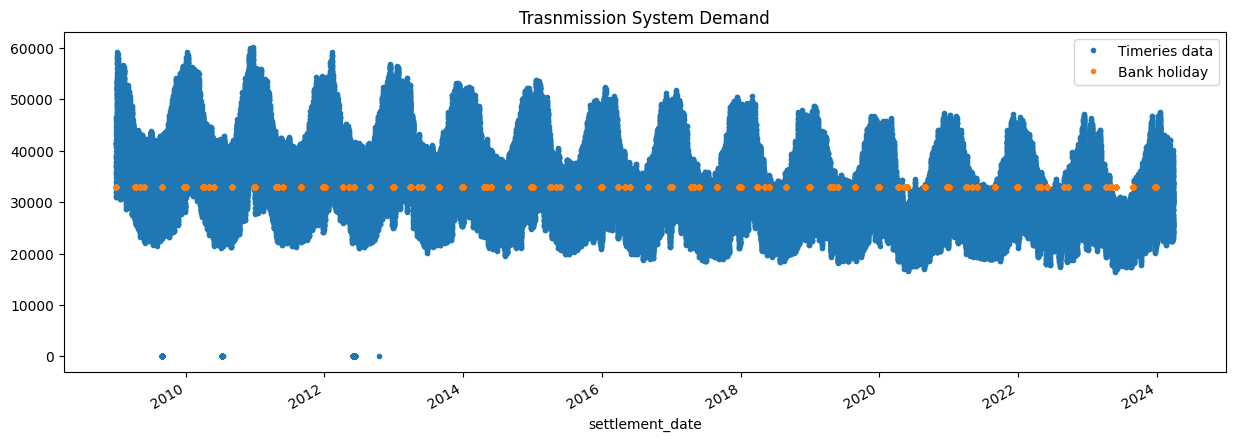

In [ ]:
# Set date as the index and turn into datetime type
df_plot = df.copy()
df_plot = df_plot.set_index("settlement_date")
df_plot.index = pd.to_datetime(df_plot.index)

fig, ax = plt.subplots(figsize=(15, 5))
df_plot["tsd"].plot(
    style=".", ax=ax, title="Trasnmission System Demand", label="Timeries data"
)
(df_plot.query("is_holiday == 1")["is_holiday"] * 33000).plot(
    style=".", ax=ax, label="Bank holiday"
)
ax.legend();

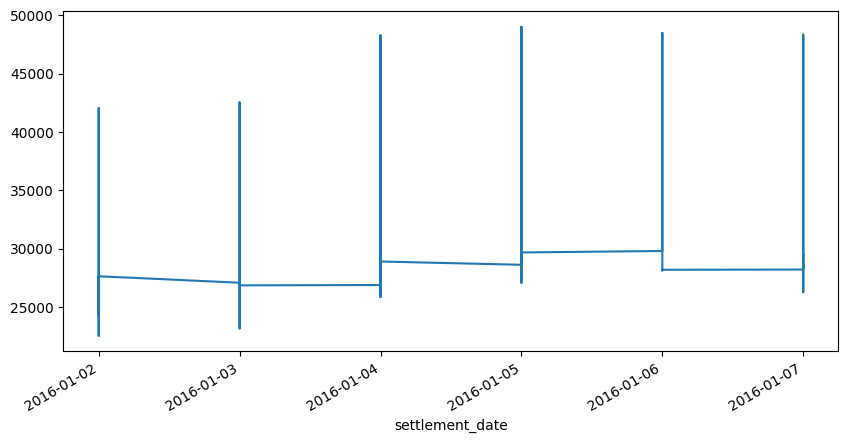

In [ ]:
df_plot.loc[(df_plot.index > "01-01-2016") & (df_plot.index < "01-08-2016")][
    "tsd"
].plot(figsize=(10, 5));

In [ ]:
df_plot.head()

,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
settlement_date,,,,,,,,,,,,,,,,,
2009-01-01,1,37910,38704,33939,54,1403,0,0,0,33,2002,0,0,-161,0,0,1
2009-01-01,2,38047,38964,34072,53,1403,0,0,0,157,2002,0,0,-160,0,0,1
2009-01-01,3,37380,38651,33615,53,1403,0,0,0,511,2002,0,0,-160,0,0,1
2009-01-01,4,36426,37775,32526,50,1403,0,0,0,589,1772,0,0,-160,0,0,1
2009-01-01,5,35687,37298,31877,50,1403,0,0,0,851,1753,0,0,-160,0,0,1


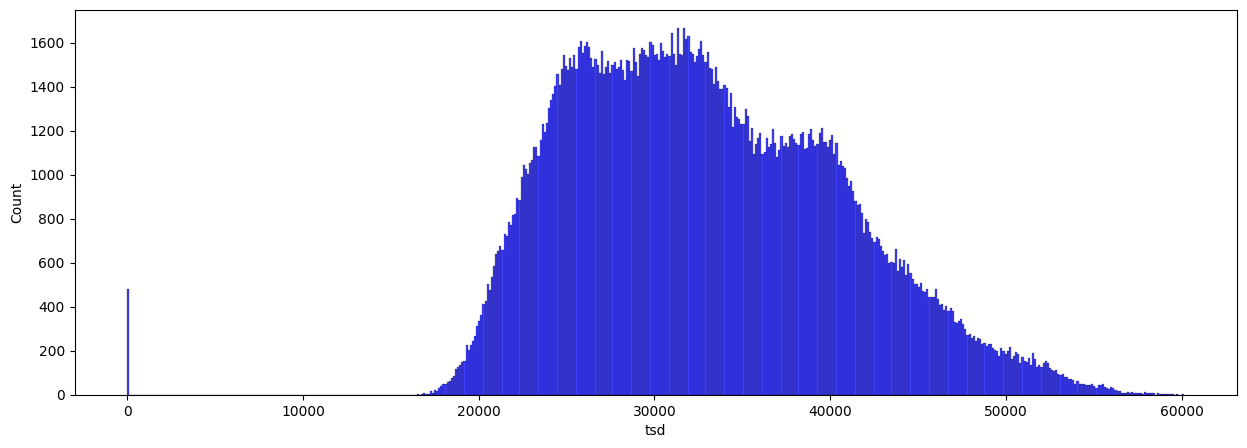

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.histplot(data=df, x="tsd", bins=500, ax=ax, color="b");

In [ ]:
null_days = df.loc[df["tsd"] == 0.0, "settlement_date"].unique().tolist()

null_days_index = []

for day in null_days:
    null_days_index.append(df[df["settlement_date"] == day].index.tolist())

null_days_index = [item for sublist in null_days_index for item in sublist]

df.drop(index=null_days_index, inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
# Apply lambda function to turn settlement period into hours.
# Settlement period equal to 0 corresponds with 00:00:00 and each
# settlement period adds 30 minutes until settlement period 48, which
# corresponds with 23:30:00
df["period_hour"] = (df["settlement_period"]).apply(
    lambda x: str(datetime.timedelta(hours=(x - 1) * 0.5))
)

df.loc[df["period_hour"] == "1 day, 0:00:00", "period_hour"] = "0:00:00"

# Move the new column
column_to_move = df.pop("period_hour")
df.insert(2, "period_hour", column_to_move)

df.sample(n=7)

,settlement_date,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
152916,2017-10-07,7,3:00:00,18984,21064,17798,2491,5305,0,12372,0,1581,295,0,633,297,441,0,0
107353,2015-03-02,38,18:30:00,48733,49881,44461,2290,4136,0,8418,64,8,1995,0,1002,-210,-394,0,0
62175,2012-08-02,24,11:30:00,37514,38274,34151,343,2085,580,1821,0,9,1995,0,992,-251,0,0,0
236896,2022-07-22,45,22:00:00,25162,27991,22771,494,6545,0,13861,0,5,-1032,-4,-264,0,126,78,0
20609,2010-03-08,20,9:30:00,48039,50815,43290,320,1829,0,0,342,18,-2048,0,0,-452,0,0,0
246534,2023-02-08,35,17:00:00,38961,41832,36462,3215,6545,0,15113,0,2,-842,-621,291,343,368,0,0
176732,2019-02-15,17,8:00:00,38808,39420,35820,1996,6192,909,13080,0,12,1999,0,1055,84,215,1000,0


As can be seen, a new column called `period_hour` includes the hour at which the electricity demand measurement was taken. One can now combine it with the actual date as follows:

In [ ]:
df["settlement_date"] = pd.to_datetime(
    (df["settlement_date"] + " " + df["period_hour"])
)

df.sample(n=5)

,settlement_date,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
68622,2012-12-15 19:00:00,39,19:00:00,43653,44562,39716,559,2085,0,2017,0,8,994,0,994,-251,-50,0,0
123608,2016-02-04 11:00:00,23,11:00:00,40926,41758,36858,1594,4126,1460,9264,0,10,1998,0,1002,-207,-15,0,0
75391,2013-05-05 20:30:00,42,20:30:00,30981,32189,28129,463,2087,0,2682,0,16,1487,0,709,-251,-441,0,0
51963,2011-12-25 16:30:00,34,16:30:00,33827,34431,30416,1420,1846,0,1116,0,4,1748,0,994,0,0,0,1
29773,2010-09-19 08:30:00,18,8:30:00,27855,28568,25108,1413,2092,2,48,0,11,1818,0,0,-202,0,0,0


The `settlement_date` column is now in the right format to use an index:

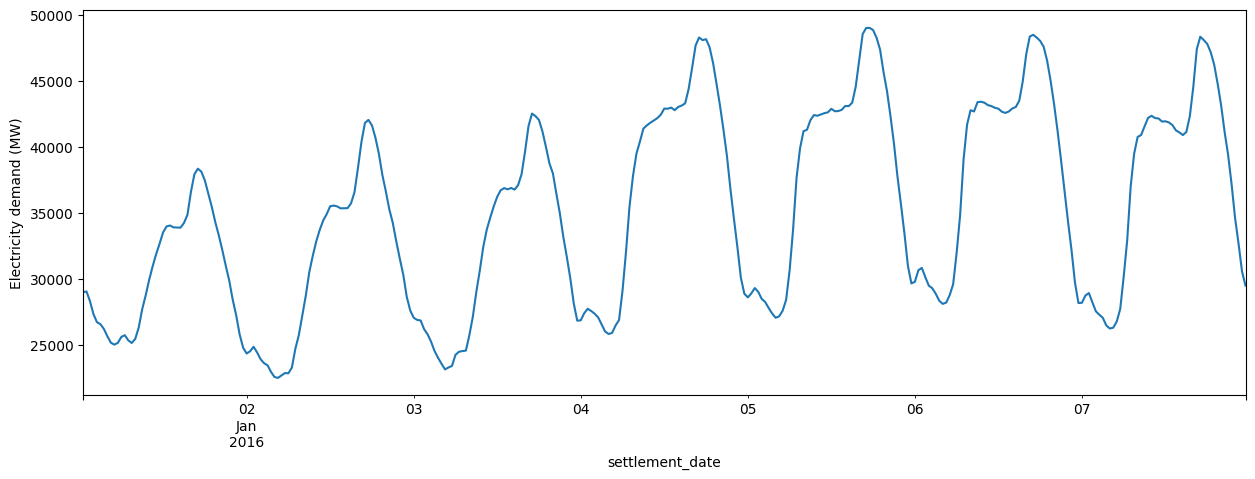

In [ ]:
df.set_index("settlement_date", inplace=True)
df.sort_index(inplace=True)

df.loc[(df.index > "01-01-2016") & (df.index < "01-08-2016")]["tsd"].plot(
    figsize=(15, 5), ylabel="Electricity demand (MW)"
);

In [ ]:
def create_features(df):
    """
    Create time series features based on time series index

    Args:
        - df: time series dataframe

    Returns:
        - df: time series dataframe with new features
    """
    df = df.copy()
    df['date'] = df.index
    df["day_of_month"] = df.index.day
    df["day_of_week"] = df.index.day_of_week
    df["day_of_year"] = df.index.day_of_year
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["week_of_year"] = df.index.isocalendar().week.astype("int64")
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300
    df['season'] = pd.cut(df['date_offset'], [0, 602,1300], labels=[0,1])
    return df

# [0, 300, 602, 900, 1300],
#labels=['Spring', 'Summer', 'Fall', 'Winter']
def add_lags(df):
    """
    Add three lags to the dataset containing information from the previous 3 years.

    Args:
        - df: time series dataframe

    Returns:
        - df: time series dataframe with lags
    """
    target_map = df["tsd"].to_dict()
    # 364 is chosen instead of 365 becuase 364 is divisible by 4 and that way we don't have to
    # map specific days
    df["lag1"] = (df.index - pd.Timedelta("364 days")).map(target_map)
    df["lag2"] = (df.index - pd.Timedelta("728 days")).map(target_map)
    df["lag3"] = (df.index - pd.Timedelta("1092 days")).map(target_map)
    return df

In [ ]:
df = create_features(df)
df = add_lags(df)


df.sample(n=10)
df[df["year"] == 2022].shape

(17518, 31)

<Axes: title={'center': 'Electricity Demand'}, xlabel='settlement_date', ylabel='MW'>

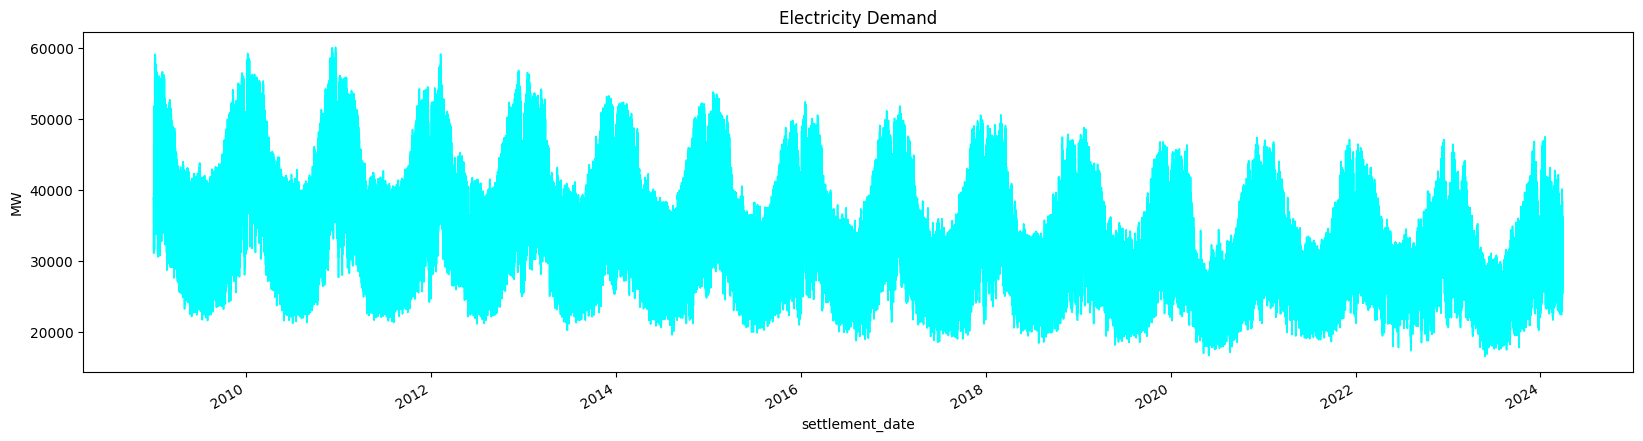

In [ ]:
df['tsd'].plot(figsize=(20,5),linewidth=1.2,cmap='cool',ylabel='MW',title='Electricity Demand')

## Feature understanding



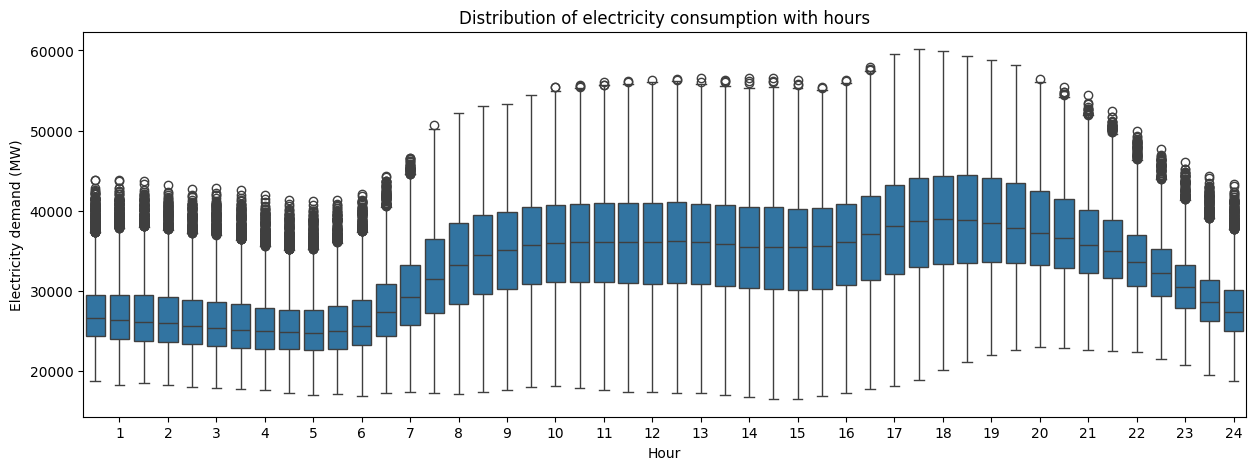

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="settlement_period", y="tsd", data=df)
# Reduce the frequency of the xticks and change the labels to be in
# the range [0,24] hours
ax.set_xticks(range(1, 49, 2))
ax.set_xticklabels(range(1, 25))
ax.set_xlabel("Hour")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with hours");

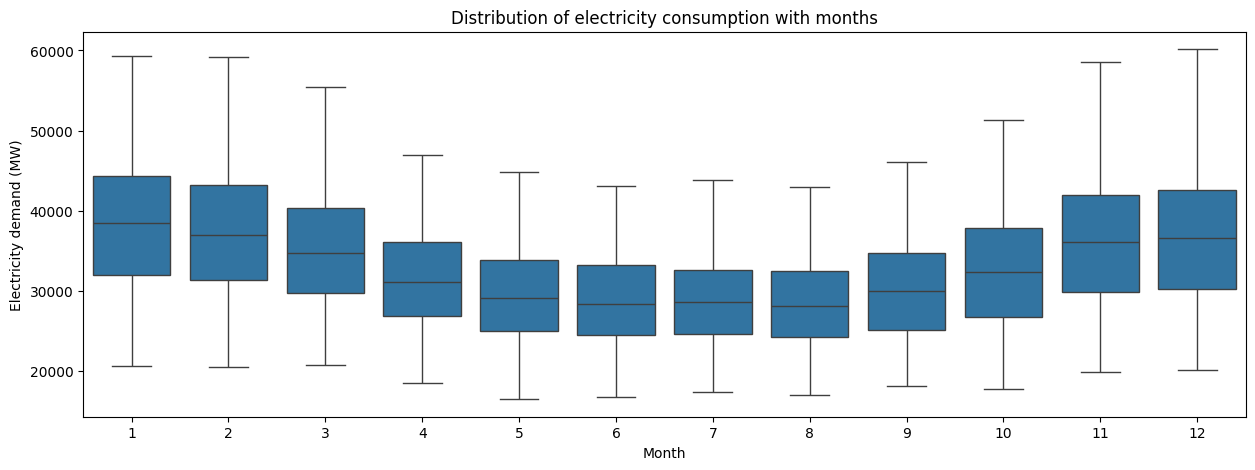

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="month", y="tsd", data=df)

ax.set_xlabel("Month")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with months");

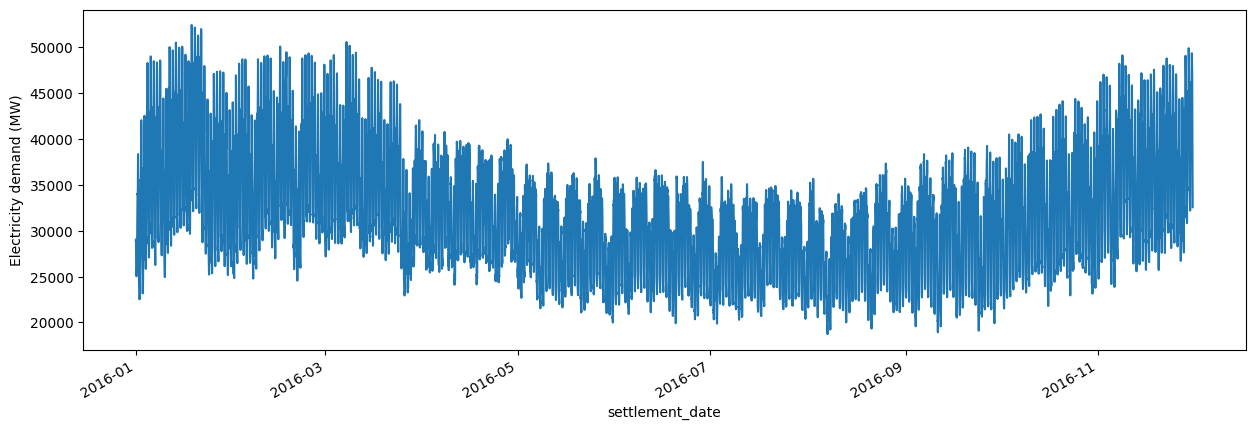

In [ ]:
df.loc[(df.index > "01-01-2016") & (df.index < "12-01-2016")]["tsd"].plot(
    figsize=(15, 5), ylabel="Electricity demand (MW)"
);

<ipython-input-72-a43933627e79>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


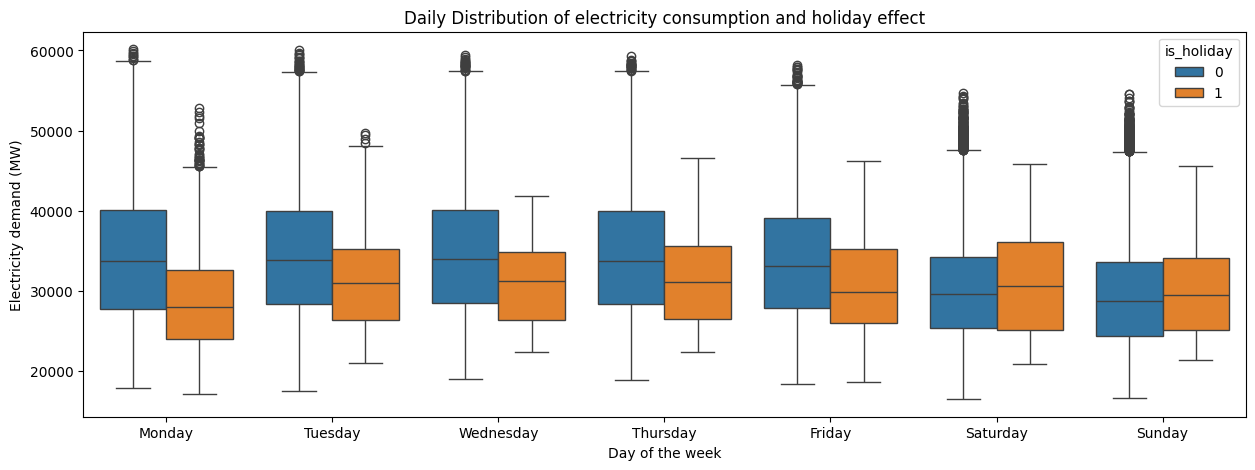

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="day_of_week", y="tsd", data=df, hue="is_holiday", ax=ax)

ax.set_xticklabels(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)
ax.set_xlabel("Day of the week")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Daily Distribution of electricity consumption and holiday effect");

from Monday to Friday, the electricity consumption is on average lower on bank holidays, whereas it is higher on Saturday and it's the same on Sundays.

For non bank holiday, the demand on the weekend is lower than during week days.

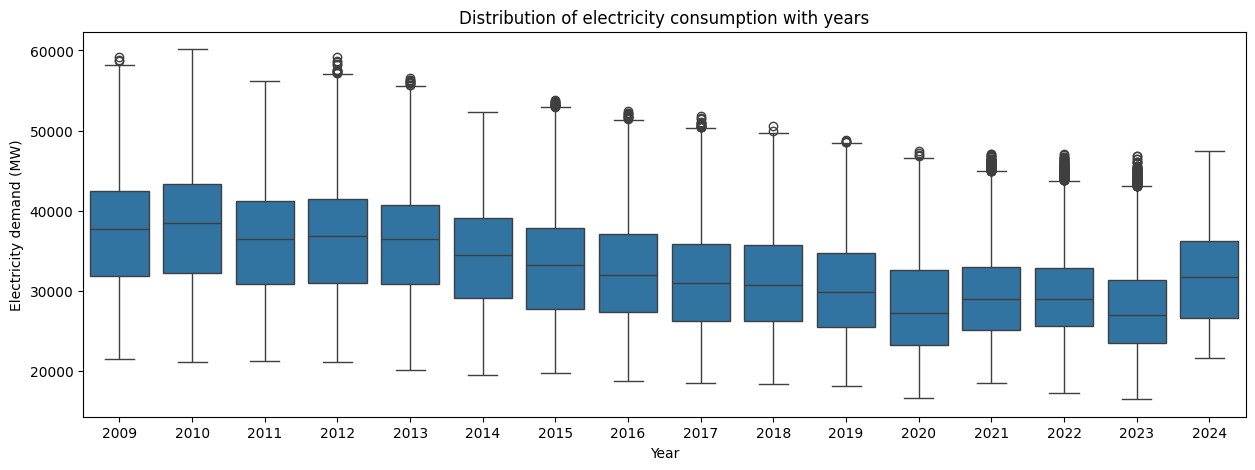

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="year", y="tsd", data=df)

ax.set_xlabel("Year")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with years");

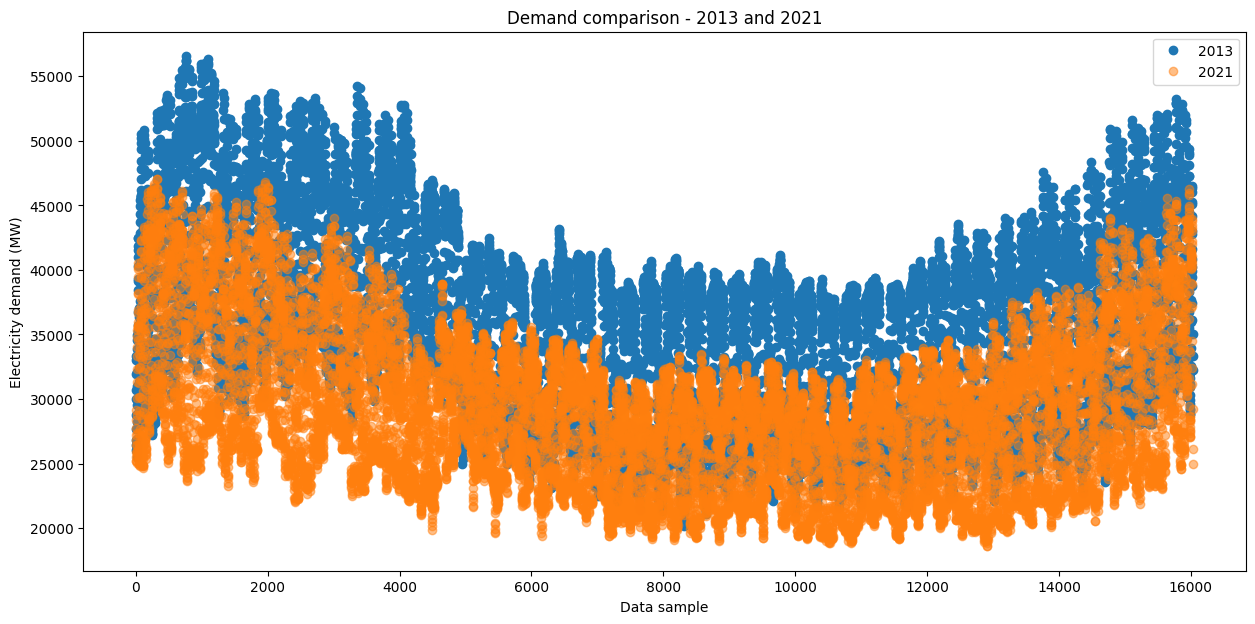

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(
    range(len(df.loc[(df.index > "01-01-2013") & (df.index < "12-01-2013")]["tsd"])),
    df.loc[(df.index > "01-01-2013") & (df.index < "12-01-2013")]["tsd"],
    "o",
    label="2013",
)

ax.plot(
    range(len(df.loc[(df.index > "01-01-2021") & (df.index < "12-01-2021")]["tsd"])),
    df.loc[(df.index > "01-01-2021") & (df.index < "12-01-2021")]["tsd"],
    "o",
    alpha=0.5,
    label="2021",
)
ax.set_xlabel("Data sample")
ax.set_ylabel("Electricity demand (MW)")
ax.legend(loc="best")
ax.set_title("Demand comparison - 2013 and 2021");

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate Mean Absolute Pertange Error given the true and
    predicted values

    Args:
        - y_true: true values
        - y_pred: predicted values

    Returns:
        - mape: MAPE value for the given predicted values
    """

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

In [ ]:
# Define rmse metric for keras to use as a loss function
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

# Train-Test Split

In [ ]:
Start = "01-01-2012"
threshold_date_1 = "01-01-2022"
threshold_date_2 = "01-01-2023"
train_data = df.loc[(df.index >= Start)&(df.index < threshold_date_1)]
val_data = df.loc[(df.index >= threshold_date_1) & (df.index < threshold_date_2)]
test_data = df.loc[(df.index >= threshold_date_2)]




# Define the features and target variable
FEATURES = [
    "is_holiday",
    "season",
    "settlement_period",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "quarter",
    "month",
    "year",
    "week_of_year",

]
TARGET = "tsd"

FEATURES_TARGET = FEATURES.copy()
FEATURES_TARGET.append(TARGET)
train_data_keras = train_data[FEATURES_TARGET]
test_data_keras = test_data[FEATURES_TARGET]
val_data_keras = val_data[FEATURES_TARGET]

y_test=test_data["tsd"]

scaler = MinMaxScaler(feature_range=(0,1))
train_data_keras_s = scaler.fit_transform(train_data_keras.values)
test_data_keras_s = scaler.transform(test_data_keras.values)
val_data_keras_s = scaler.transform(val_data_keras.values)

X_train_keras = (
    train_data_keras_s[:,:-1].
    reshape(train_data_keras_s.shape[0],1,len(FEATURES))
)
y_train_keras = train_data_keras_s[:,-1]

X_test_keras = (
    test_data_keras_s[:,:-1].
    reshape(test_data_keras_s.shape[0],1,len(FEATURES))
)
y_test_keras = test_data_keras_s[:,-1]

X_val_keras = (
    val_data_keras_s[:,:-1].
    reshape(val_data_keras_s.shape[0],1,len(FEATURES))
)
y_val_keras = val_data_keras_s[:,-1]

test_data_keras.head()

/usr/local/lib/python3.10/dist-packages/pandas/core/arrays/base.py:485: RuntimeWarning: invalid value encountered in cast
  result = np.asarray(self, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/pandas/core/arrays/base.py:485: RuntimeWarning: invalid value encountered in cast
  result = np.asarray(self, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/pandas/core/arrays/base.py:485: RuntimeWarning: invalid value encountered in cast
  result = np.asarray(self, dtype=dtype)


,is_holiday,season,settlement_period,day_of_month,day_of_week,day_of_year,quarter,month,year,week_of_year,tsd
settlement_date,,,,,,,,,,,
2023-01-01 00:00:00,1,1,1,1,6,1,1,1,2023,52,24680
2023-01-01 00:30:00,1,1,2,1,6,1,1,1,2023,52,25289
2023-01-01 01:00:00,1,1,3,1,6,1,1,1,2023,52,25269
2023-01-01 01:30:00,1,1,4,1,6,1,1,1,2023,52,24574
2023-01-01 02:00:00,1,1,5,1,6,1,1,1,2023,52,24135


# Deep LSTM

In [ ]:
# Create and compile neural network
tf.random.set_seed(221)
model = Sequential()
model.add(LSTM(256, input_shape=(X_train_keras.shape[1], X_train_keras.shape[2]), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dropout(0.5))

model.add(Dense(1))
model.compile(loss = root_mean_squared_error, optimizer="adam")

# Define callbacks
monitor_param = root_mean_squared_error
mode="min"
early_stopping = EarlyStopping(monitor=root_mean_squared_error, patience=8, verbose=0, mode=mode)
checkpoint_save = ModelCheckpoint(
    "./models_data/deep_lstm/checkpoint",
    save_weights_only=True,
    monitor=monitor_param,
    mode=mode,
)
reduce_lr_loss = ReduceLROnPlateau(
    monitor=monitor_param, factor=0.1, patience=5, verbose=0, mode=mode
)

# Fit model
history_deep_lstm = model.fit(
    X_train_keras,
    y_train_keras,
    epochs=50,
    batch_size=144,
    validation_data=(X_val_keras, y_val_keras),
    callbacks=[early_stopping, checkpoint_save, reduce_lr_loss]
)

Epoch 1/50
1211/1215 [============================>.] - ETA: 0s - loss: 0.1287

1215/1215 [==============================] - 15s 9ms/step - loss: 0.1287 - val_loss: 0.0904 - lr: 0.0010
Epoch 2/50
1211/1215 [============================>.] - ETA: 0s - loss: 0.0922

1215/1215 [==============================] - 8s 7ms/step - loss: 0.0921 - val_loss: 0.0786 - lr: 0.0010
Epoch 3/50
1211/1215 [============================>.] - ETA: 0s - loss: 0.0837

1215/1215 [==============================] - 10s 8ms/step - loss: 0.0837 - val_loss: 0.0693 - lr: 0.0010
Epoch 4/50
1215/1215 [==============================] - ETA: 0s - loss: 0.0755

1215/1215 [==============================] - 10s 8ms/step - loss: 0.0755 - val_loss: 0.0640 - lr: 0.0010
Epoch 5/50
1213/1215 [============================>.] - ETA: 0s - loss: 0.0717

1215/1215 [==============================] - 10s 8ms/step - loss: 0.0717 - val_loss: 0.0633 - lr: 0.0010
Epoch 6/50
1215/1215 [==============================] - ETA: 0s - loss: 0.0699

1215/1215 [==============================] - 10s 8ms/step - loss: 0.0699 - val_loss: 0.0619 - lr: 0.0010
Epoch 7/50
1212/1215 [============================>.] - ETA: 0s - loss: 0.0688

1215/1215 [==============================] - 9s 8ms/step - loss: 0.0688 - val_loss: 0.0619 - lr: 0.0010
Epoch 8/50
1215/1215 [==============================] - ETA: 0s - loss: 0.0681

1215/1215 [==============================] - 8s 7ms/step - loss: 0.0681 - val_loss: 0.0622 - lr: 0.0010
Epoch 9/50
1207/1215 [============================>.] - ETA: 0s - loss: 0.0675

1215/1215 [==============================] - 10s 8ms/step - loss: 0.0675 - val_loss: 0.0654 - lr: 0.0010
Epoch 10/50
1211/1215 [============================>.] - ETA: 0s - loss: 0.0667

1215/1215 [==============================] - 9s 7ms/step - loss: 0.0666 - val_loss: 0.0640 - lr: 0.0010
Epoch 11/50
1214/1215 [============================>.] - ETA: 0s - loss: 0.0658

1215/1215 [==============================] - 9s 7ms/step - loss: 0.0658 - val_loss: 0.0621 - lr: 0.0010
Epoch 12/50
1208/1215 [============================>.] - ETA: 0s - loss: 0.0653

1215/1215 [==============================] - 9s 8ms/step - loss: 0.0653 - val_loss: 0.0603 - lr: 0.0010
Epoch 13/50
1213/1215 [============================>.] - ETA: 0s - loss: 0.0650

1215/1215 [==============================] - 8s 7ms/step - loss: 0.0650 - val_loss: 0.0606 - lr: 0.0010
Epoch 14/50
1213/1215 [============================>.] - ETA: 0s - loss: 0.0646

1215/1215 [==============================] - 9s 8ms/step - loss: 0.0646 - val_loss: 0.0600 - lr: 0.0010
Epoch 15/50
1214/1215 [============================>.] - ETA: 0s - loss: 0.0641

1215/1215 [==============================] - 9s 8ms/step - loss: 0.0641 - val_loss: 0.0611 - lr: 0.0010
Epoch 16/50
1214/1215 [============================>.] - ETA: 0s - loss: 0.0637

1215/1215 [==============================] - 9s 7ms/step - loss: 0.0637 - val_loss: 0.0632 - lr: 0.0010
Epoch 17/50
1209/1215 [============================>.] - ETA: 0s - loss: 0.0635

1215/1215 [==============================] - 9s 8ms/step - loss: 0.0635 - val_loss: 0.0581 - lr: 0.0010
Epoch 18/50
1214/1215 [============================>.] - ETA: 0s - loss: 0.0630

1215/1215 [==============================] - 9s 8ms/step - loss: 0.0630 - val_loss: 0.0600 - lr: 0.0010
Epoch 19/50
1210/1215 [============================>.] - ETA: 0s - loss: 0.0627

1215/1215 [==============================] - 9s 8ms/step - loss: 0.0627 - val_loss: 0.0572 - lr: 0.0010
Epoch 20/50
1208/1215 [============================>.] - ETA: 0s - loss: 0.0624

1215/1215 [==============================] - 10s 8ms/step - loss: 0.0624 - val_loss: 0.0566 - lr: 0.0010
Epoch 21/50
1212/1215 [============================>.] - ETA: 0s - loss: 0.0620

1215/1215 [==============================] - 9s 7ms/step - loss: 0.0620 - val_loss: 0.0574 - lr: 0.0010
Epoch 22/50
1211/1215 [============================>.] - ETA: 0s - loss: 0.0619

1215/1215 [==============================] - 11s 9ms/step - loss: 0.0619 - val_loss: 0.0572 - lr: 0.0010
Epoch 23/50
1212/1215 [============================>.] - ETA: 0s - loss: 0.0615

1215/1215 [==============================] - 9s 8ms/step - loss: 0.0615 - val_loss: 0.0558 - lr: 0.0010
Epoch 24/50
1215/1215 [==============================] - ETA: 0s - loss: 0.0616

1215/1215 [==============================] - 8s 7ms/step - loss: 0.0616 - val_loss: 0.0577 - lr: 0.0010
Epoch 25/50
1214/1215 [============================>.] - ETA: 0s - loss: 0.0613

1215/1215 [==============================] - 9s 8ms/step - loss: 0.0613 - val_loss: 0.0565 - lr: 0.0010
Epoch 26/50
1213/1215 [============================>.] - ETA: 0s - loss: 0.0610

1215/1215 [==============================] - 9s 7ms/step - loss: 0.0610 - val_loss: 0.0573 - lr: 0.0010
Epoch 27/50
1212/1215 [============================>.] - ETA: 0s - loss: 0.0608

1215/1215 [==============================] - 9s 8ms/step - loss: 0.0608 - val_loss: 0.0583 - lr: 0.0010
Epoch 28/50
1212/1215 [============================>.] - ETA: 0s - loss: 0.0606

1215/1215 [==============================] - 10s 8ms/step - loss: 0.0606 - val_loss: 0.0562 - lr: 0.0010
Epoch 29/50
1215/1215 [==============================] - ETA: 0s - loss: 0.0603

1215/1215 [==============================] - 9s 7ms/step - loss: 0.0603 - val_loss: 0.0567 - lr: 0.0010
Epoch 30/50
1213/1215 [============================>.] - ETA: 0s - loss: 0.0601

1215/1215 [==============================] - 9s 8ms/step - loss: 0.0601 - val_loss: 0.0573 - lr: 0.0010
Epoch 31/50
1214/1215 [============================>.] - ETA: 0s - loss: 0.0600

1215/1215 [==============================] - 9s 8ms/step - loss: 0.0600 - val_loss: 0.0552 - lr: 0.0010
Epoch 32/50
1208/1215 [============================>.] - ETA: 0s - loss: 0.0598

1215/1215 [==============================] - 8s 7ms/step - loss: 0.0598 - val_loss: 0.0562 - lr: 0.0010
Epoch 33/50
1215/1215 [==============================] - ETA: 0s - loss: 0.0596

1215/1215 [==============================] - 10s 8ms/step - loss: 0.0596 - val_loss: 0.0554 - lr: 0.0010
Epoch 34/50
1214/1215 [============================>.] - ETA: 0s - loss: 0.0595

1215/1215 [==============================] - 9s 7ms/step - loss: 0.0595 - val_loss: 0.0582 - lr: 0.0010
Epoch 35/50
1211/1215 [============================>.] - ETA: 0s - loss: 0.0595

1215/1215 [==============================] - 9s 8ms/step - loss: 0.0595 - val_loss: 0.0540 - lr: 0.0010
Epoch 36/50
1208/1215 [============================>.] - ETA: 0s - loss: 0.0593

1215/1215 [==============================] - 9s 8ms/step - loss: 0.0593 - val_loss: 0.0567 - lr: 0.0010
Epoch 37/50
1213/1215 [============================>.] - ETA: 0s - loss: 0.0593

1215/1215 [==============================] - 8s 7ms/step - loss: 0.0593 - val_loss: 0.0578 - lr: 0.0010
Epoch 38/50
1213/1215 [============================>.] - ETA: 0s - loss: 0.0591

1215/1215 [==============================] - 11s 9ms/step - loss: 0.0591 - val_loss: 0.0559 - lr: 0.0010
Epoch 39/50
1215/1215 [==============================] - ETA: 0s - loss: 0.0590

1215/1215 [==============================] - 9s 7ms/step - loss: 0.0590 - val_loss: 0.0549 - lr: 0.0010
Epoch 40/50
1214/1215 [============================>.] - ETA: 0s - loss: 0.0587

1215/1215 [==============================] - 9s 8ms/step - loss: 0.0587 - val_loss: 0.0589 - lr: 0.0010
Epoch 41/50
1214/1215 [============================>.] - ETA: 0s - loss: 0.0587

1215/1215 [==============================] - 9s 8ms/step - loss: 0.0587 - val_loss: 0.0556 - lr: 0.0010
Epoch 42/50
1209/1215 [============================>.] - ETA: 0s - loss: 0.0586

1215/1215 [==============================] - 8s 7ms/step - loss: 0.0586 - val_loss: 0.0560 - lr: 0.0010
Epoch 43/50
1214/1215 [============================>.] - ETA: 0s - loss: 0.0585

1215/1215 [==============================] - 10s 8ms/step - loss: 0.0585 - val_loss: 0.0582 - lr: 0.0010
Epoch 44/50
1210/1215 [============================>.] - ETA: 0s - loss: 0.0586

1215/1215 [==============================] - 9s 8ms/step - loss: 0.0586 - val_loss: 0.0609 - lr: 0.0010
Epoch 45/50
1212/1215 [============================>.] - ETA: 0s - loss: 0.0581

1215/1215 [==============================] - 9s 7ms/step - loss: 0.0581 - val_loss: 0.0568 - lr: 0.0010
Epoch 46/50
1212/1215 [============================>.] - ETA: 0s - loss: 0.0581

1215/1215 [==============================] - 10s 8ms/step - loss: 0.0581 - val_loss: 0.0586 - lr: 0.0010
Epoch 47/50
1210/1215 [============================>.] - ETA: 0s - loss: 0.0581

1215/1215 [==============================] - 8s 7ms/step - loss: 0.0581 - val_loss: 0.0543 - lr: 0.0010
Epoch 48/50
1213/1215 [============================>.] - ETA: 0s - loss: 0.0581

1215/1215 [==============================] - 9s 8ms/step - loss: 0.0581 - val_loss: 0.0543 - lr: 0.0010
Epoch 49/50
1214/1215 [============================>.] - ETA: 0s - loss: 0.0580

1215/1215 [==============================] - 10s 8ms/step - loss: 0.0580 - val_loss: 0.0571 - lr: 0.0010
Epoch 50/50
1214/1215 [============================>.] - ETA: 0s - loss: 0.0581

1215/1215 [==============================] - 9s 7ms/step - loss: 0.0581 - val_loss: 0.0570 - lr: 0.0010


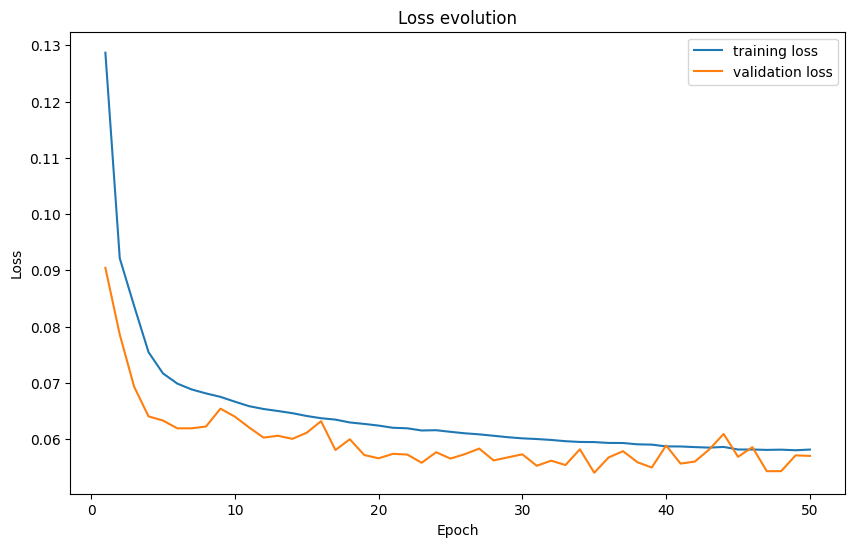

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    range(1, len(history_deep_lstm.history["loss"]) + 1),
    history_deep_lstm.history["loss"],
    label="training loss",
)
ax.plot(
    range(1, len(history_deep_lstm.history["loss"]) + 1),
    history_deep_lstm.history["val_loss"],
    label="validation loss",
)

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss evolution")
ax.legend(loc="best");

Similarly to the previous LSTM model, the output needs to inverse transformed.

In [ ]:
# Prediction on test set
result_frame=test_data_keras.copy()
pred_deep_lstm = model.predict(X_test_keras)

# Inverse transform the prediction
# Since scaler was fit using all the data (9 features + outcome variable)
# we need to store the prediction in the a copy of the original data
results_deep_lstm = test_data_keras_s
results_deep_lstm[:,-1] = pred_deep_lstm.reshape(pred_deep_lstm.shape[0])
results_deep_lstm = scaler.inverse_transform(results_deep_lstm)

# Store inverse transformed preductons in the result dataframe
result_frame["pred_deep_lstm"] = results_deep_lstm[:,-1]

680/680 [==============================] - 3s 4ms/step


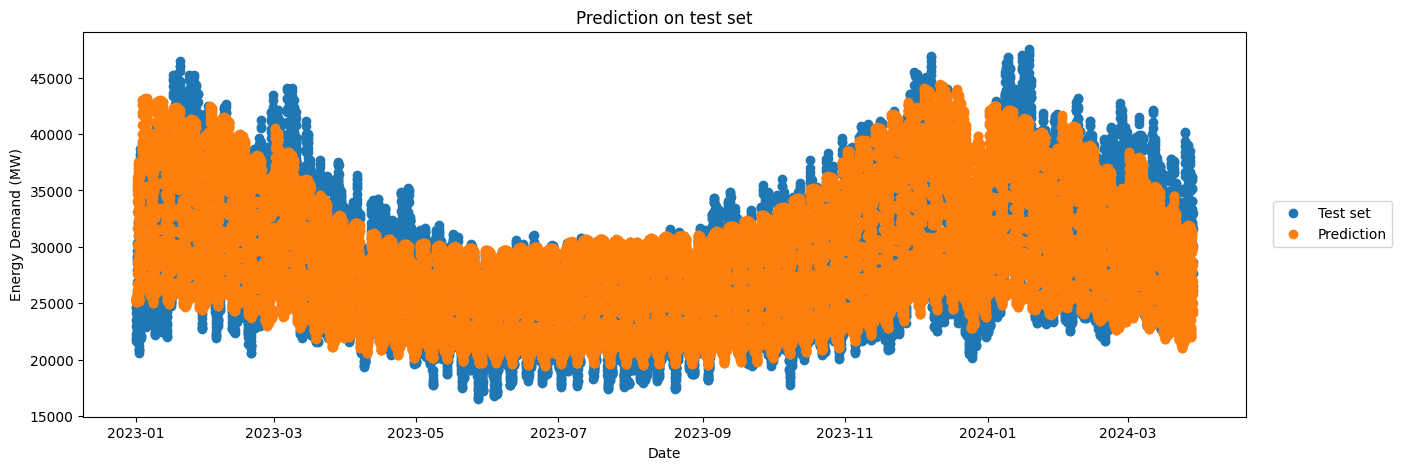

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test set")
ax.plot(result_frame.index, result_frame["pred_deep_lstm"], "o", label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

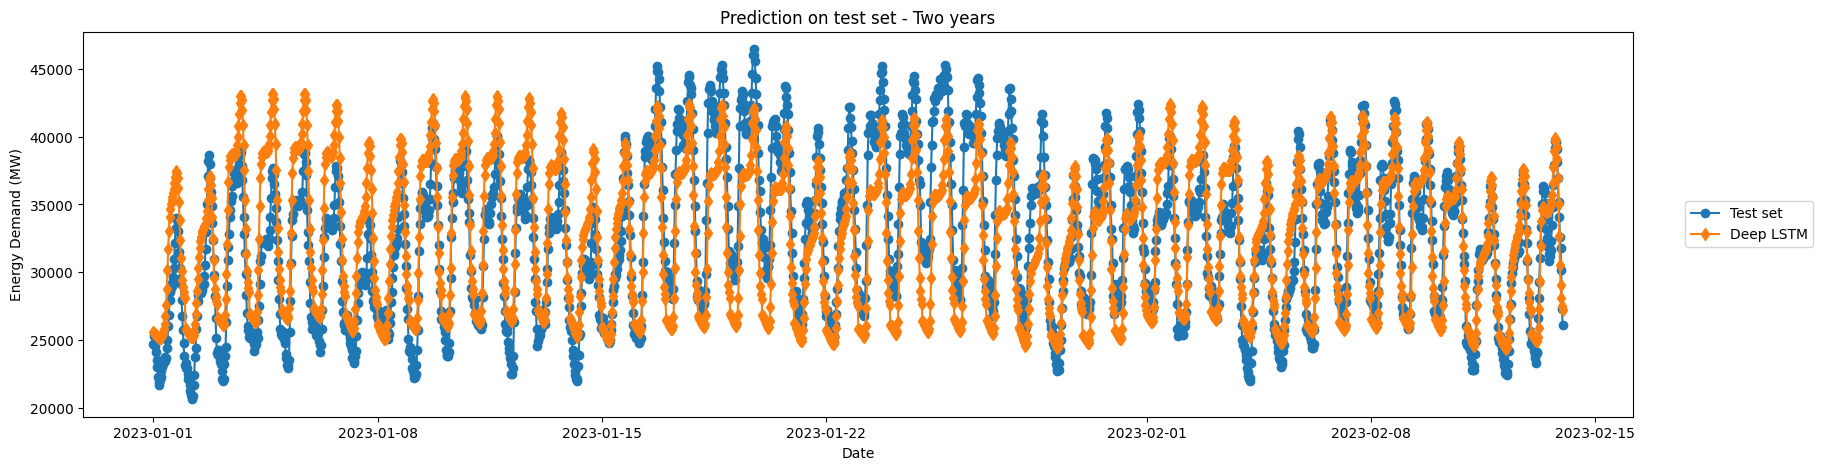

In [ ]:
begin = "02-01-2021"
end = "02-14-2023"

fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["tsd"],
    "-o",
    label="Test set",
)

"""
ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_lstm"
    ],
    "-s",
    label="LSTM",
)
"""
ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_deep_lstm"
    ],
    "-d",
    label="Deep LSTM",
)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set - Two years")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

In [ ]:
mape_deep_lstm = mean_absolute_percentage_error(
    y_test, result_frame["pred_deep_lstm"]
)

rmse_deep_lstm = np.sqrt(mean_squared_error(y_test, result_frame["pred_deep_lstm"]))

print(
    "Mean Absolute Percentage Error of the deep LSTM model is: %.2f" % mape_deep_lstm
)

print(
    "Root Mean Squared Error of the deep LSTM model is: %.2f MW" % rmse_deep_lstm
)

Mean Absolute Percentage Error of the deep LSTM model is: 6.94
Root Mean Squared Error of the deep LSTM model is: 2616.25 MW


# Summary of the results and key insights



In [ ]:
summary_df = pd.DataFrame(
    {


        "Deep LSTM": [mape_deep_lstm, rmse_deep_lstm],
        "Metric": ["MAPE", "RMSE"]
    }
)

summary_df.set_index("Metric", inplace=True)

summary_df.style.format('{:.2f}')

,Deep LSTM
Metric,
MAPE,6.94
RMSE,2616.25
